# Watson Visual Recognition Training with Spectrogram Images from SETI Signal Data

* https://www.ibm.com/watson/developercloud/visual-recognition/api/v3/
* https://www.ibm.com/watson/developercloud/doc/visual-recognition/customizing.html
* https://github.com/watson-developer-cloud/python-sdk
* https://github.com/watson-developer-cloud/python-sdk/blob/master/watson_developer_cloud/visual_recognition_v3.py

<hr>

## Install the Watson Developer Cloud Python SDK

* Install the Python SDK if has not been previously installed **`!pip install --upgrade watson-developer-cloud`**
* Restart the kernel, after installing the SDK

In [3]:
#!pip install --user --upgrade watson-developer-cloud

In [4]:
#Making a local folder to put my data.

#NOTE: YOU MUST do something like this on a Spark Enterprise cluster at the hackathon so that
#you can put your data into a separate local file space. Otherwise, you'll likely collide with 
#your fellow participants. 

my_team_name_data_folder = 'my_team_name_data_folder'

mydatafolder = os.environ['PWD'] + '/' +  my_team_name_data_folder + '/zipfiles'
if os.path.exists(mydatafolder) is False:
    os.makedirs(mydatafolder)

In [5]:
!ls -al $mydatafolder

total 4168752
drwx------ 2 sd2d-634b36332a0fab-8605aaf2c6e1 users    16384 Jun  9 19:57 .
drwx------ 4 sd2d-634b36332a0fab-8605aaf2c6e1 users     4096 Jun  9 19:52 ..
-rw------- 1 sd2d-634b36332a0fab-8605aaf2c6e1 users 18861624 Jun  9 19:55 classification_10_narrowbanddrd.zip
-rw------- 1 sd2d-634b36332a0fab-8605aaf2c6e1 users 15728896 Jun  9 19:55 classification_10_narrowband.zip
-rw------- 1 sd2d-634b36332a0fab-8605aaf2c6e1 users  1010329 Jun  9 19:55 classification_10_noise.zip
-rw------- 1 sd2d-634b36332a0fab-8605aaf2c6e1 users 10639276 Jun  9 19:54 classification_10_squiggle.zip
-rw------- 1 sd2d-634b36332a0fab-8605aaf2c6e1 users 26276682 Jun  9 19:55 classification_1_narrowbanddrd.zip
-rw------- 1 sd2d-634b36332a0fab-8605aaf2c6e1 users 26540364 Jun  9 19:54 classification_1_narrowband.zip
-rw------- 1 sd2d-634b36332a0fab-8605aaf2c6e1 users 26524332 Jun  9 19:55 classification_1_noise.zip
-rw------- 1 sd2d-634b36332a0fab-8605aaf2c6e1 users 26500379 Jun  9 19:54 classification_1_sq

In [6]:
from __future__ import division

import cStringIO
import glob
import json
import numpy
import os
import re
import requests
import time
import timeit
import zipfile
import copy

from random import randint

import matplotlib.pyplot as plt
import numpy as np

import ibmseti

from watson_developer_cloud import VisualRecognitionV3

In [7]:
apiVer = VisualRecognitionV3.latest_version #'2016-05-20'
classifier_prefix = 'setisignals'

#You can sign up with WatsonVR through Bluemix to get a key
#However, Hackathon participants will be provided with a WATSON VR key that has more free API calls per day.
apiKey = 'WATSON-VISUAL-RECOGNITION-API-KEY'  
# TODO: remove before publication
apiKey = '6509560f06b4bc06ebbfa393e58214d92e40b8d6'  

<br/>
## Init the Watson Visual Recognition Python Library

* you may need to install the SDK first: **`!pip install --upgrade watson-developer-cloud`**
* you will need the **API** key from the Watson Visual Recognition Service

In [8]:
vr = VisualRecognitionV3(apiVer, api_key=apiKey)

<br/>
## Look For Existing Custom Classifier
Use an existing custom classifier (and update) if one exists, else a new custom classifier will be created

In [9]:
## View all of your classifiers

classifiers = vr.list_classifiers()
print json.dumps(classifiers, indent=2)

{
  "classifiers": [
    {
      "status": "ready", 
      "classifier_id": "setisignals_344356204", 
      "name": "setisignals"
    }
  ]
}


In [10]:
## Run this cell ONLY IF you want to REMOVE all classifiers
# Otherwise, the subsequent cell will append images to the `classifier_prefix` classifier
classifiers = vr.list_classifiers()
for c in classifiers['classifiers']:
    vr.delete_classifier(c['classifier_id'])

In [11]:
classifiers = vr.list_classifiers()
print json.dumps(classifiers, indent=2)

{
  "classifiers": []
}


In [12]:
#Create new classifier, or get the ID for the latest SETISIGNALS classifier

classifier_id = None
classifier = None

classifiers = vr.list_classifiers()

for c in classifiers['classifiers']:
    if c['status'] == 'ready' and (classifier_prefix in c['classifier_id']):
        classifier_id = c['classifier_id']


if classifier_id is not None:
    classifier = vr.get_classifier(classifier_id)
    print '\r\nFound classifer:\r\n\r\n{}'.format(json.dumps(classifier, indent=2))
else:
    print 'No custom classifier available\r\n'
    print(json.dumps(classifiers, indent=2))

No custom classifier available

{
  "classifiers": []
}


<br/>
## Send the Images Archives to the Watson Visual Recognition Service for Training

* https://www.ibm.com/watson/developercloud/doc/visual-recognition/customizing.html
* https://www.ibm.com/watson/developercloud/visual-recognition/api/v3/
* https://github.com/watson-developer-cloud/python-sdk

In [13]:
squiggle = sorted(glob.glob('{}/classification_*_squiggle.zip'.format(mydatafolder)))
narrowband = sorted(glob.glob('{}/classification_*_narrowband.zip'.format(mydatafolder)))
narrowbanddrd = sorted(glob.glob('{}/classification_*_narrowbanddrd.zip'.format(mydatafolder)))
noise = sorted(glob.glob('{}/classification_*_noise.zip'.format(mydatafolder)))

sq = len(squiggle)
nb = len(narrowband)
nd = len(narrowbanddrd)
ns = len(noise)

## Possible todo here: Try using the 'noise' as a "negative" example when training Watson. See the Watson documentation.

num = max(sq, nb, nd, ns)
#num = max(sq, nb, nd)

if classifier_id is None:
    print 'Adding custom classifier ... this may take awhile'
else:
    print 'Updating custom classifier {} ... this may take awhile'.format(classifier_id)

for i in range(num):
    squiggle_p = open(squiggle[i], 'rb') if i < sq else None
    narrowband_p = open(narrowband[i], 'rb') if i < nb else None
    narrowbanddrd_p = open(narrowbanddrd[i], 'rb') if i < nd else None
    noise_p = open(noise[i], 'rb') if i < ns else None

    if classifier_id is None:
#        print 'Creating with\r\n{}\r\n{}\r\n{}\r'.format(squiggle_p, narrowband_p, narrowbanddrd_p)  #use this line if going to use 'noise' as negative example
        print 'Creating with\r\n{}\r\n{}\r\n{}\r\n{}\r'.format(squiggle_p, narrowband_p, narrowbanddrd_p, noise_p)
        classifier = vr.create_classifier(
            classifier_prefix,
            squiggle_positive_examples = squiggle_p,
            narrowband_positive_examples = narrowband_p,
            narrowbanddrd_positive_examples = narrowbanddrd_p,
            noise_positive_examples = noise_p  #remove this if going to use noise as 'negative' examples
        )
        
        classifier_id = classifier['classifier_id']
    else:
        print 'Updating with\r\n{}\r\n{}\r\n{}\r\n{}\r'.format(squiggle_p, narrowband_p, narrowbanddrd_p, noise_p)
#        print 'Updating with\r\n{}\r\n{}\r\n{}\r'.format(squiggle_p, narrowband_p, narrowbanddrd_p)  #use this line if going to use 'noise' as negative example
        classifier = vr.update_classifier(
            classifier_id,
            squiggle_positive_examples = squiggle_p,
            narrowband_positive_examples = narrowband_p,
            narrowbanddrd_positive_examples = narrowbanddrd_p,
            noise_positive_examples = noise_p #remove this if going to use noise as 'negative' examples
        )

    if squiggle_p is not None:
        squiggle_p.close()
    if narrowband_p is not None:
        narrowband_p.close()
    if narrowbanddrd_p is not None:
        narrowbanddrd_p.close()
    if noise_p is not None:
        noise_p.close()

    if classifier is not None:
        print('Classifier: {}'.format(classifier_id))
        status = classifier['status']
        startTimer = timeit.default_timer()
        while status in ['training', 'retraining']:
            print('Status: {}'.format(status))
            time.sleep(10)
            classifier = vr.get_classifier(classifier_id)
            status = classifier['status']
        stopTimer = timeit.default_timer()
        print '{} took {} minutes'.format('Training' if i == 0 else 'Retraining', int(stopTimer - startTimer) / 60)

print(json.dumps(vr.get_classifier(classifier_id), indent=2))


Adding custom classifier ... this may take awhile
Creating with
<open file '/gpfs/fs01/user/sd2d-634b36332a0fab-8605aaf2c6e1/notebook/work/my_team_name_data_folder/zipfiles/classification_10_squiggle.zip', mode 'rb' at 0x7f86710f2f60>
<open file '/gpfs/fs01/user/sd2d-634b36332a0fab-8605aaf2c6e1/notebook/work/my_team_name_data_folder/zipfiles/classification_10_narrowband.zip', mode 'rb' at 0x7f867107b150>
<open file '/gpfs/fs01/user/sd2d-634b36332a0fab-8605aaf2c6e1/notebook/work/my_team_name_data_folder/zipfiles/classification_10_narrowbanddrd.zip', mode 'rb' at 0x7f867107b1e0>
<open file '/gpfs/fs01/user/sd2d-634b36332a0fab-8605aaf2c6e1/notebook/work/my_team_name_data_folder/zipfiles/classification_10_noise.zip', mode 'rb' at 0x7f867107b270>
Classifier: setisignals_1997353171
Status: training
Status: training
Status: training
Training took 0.516666666667 minutes
Updating with
<open file '/gpfs/fs01/user/sd2d-634b36332a0fab-8605aaf2c6e1/notebook/work/my_team_name_data_folder/zipfiles/cl

<br/>
## Take a Random Data File for Testing

* Take a random data file from the test set
* Create a Spectrogram Image

In [14]:
zz = zipfile.ZipFile(mydatafolder + '/' + 'testset_1_narrowband.zip')

In [15]:
test_list = zz.namelist()
randomSignal = zz.open(test_list[10],'r')

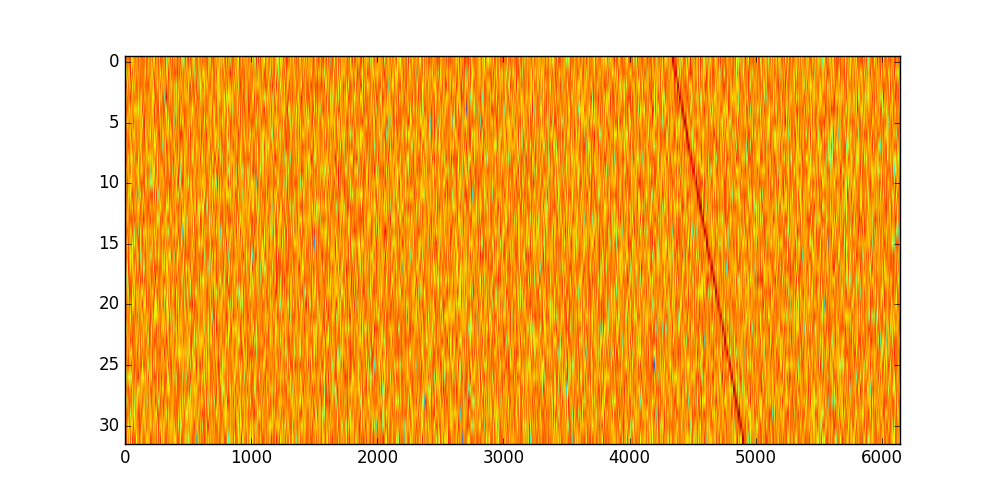

In [16]:
from IPython.display import Image
squigImg = randomSignal.read()
Image(squigImg)

In [17]:
#note - have to 'open' this again because it was already .read() out in the line above
randomSignal = zz.open(test_list[10],'r')

url_result = vr.classify(images_file=randomSignal, classifier_ids=classifier_id, threshold=0.0)

print(json.dumps(url_result, indent=2))

{
  "images": [
    {
      "image": "gpfs/fs01/user/sd2d-634b36332a0fab-8605aaf2c6e1/notebook/work/my_team_name_data_folder/png/86a3cde6-be85-4130-a2a7-d374c2fd16ff.dat.png", 
      "classifiers": [
        {
          "classes": [
            {
              "score": 0.625134, 
              "class": "narrowband"
            }, 
            {
              "score": 0.471323, 
              "class": "narrowbanddrd"
            }, 
            {
              "score": 0.154072, 
              "class": "noise"
            }, 
            {
              "score": 0.057637, 
              "class": "squiggle"
            }
          ], 
          "classifier_id": "setisignals_1997353171", 
          "name": "setisignals"
        }
      ]
    }
  ], 
  "custom_classes": 4, 
  "images_processed": 1
}


<br/>
## Run the Complete Test Set



In [18]:
#Create a dictionary object to store results from Watson

from collections import defaultdict

class_list = ['squiggle', 'noise', 'narrowband', 'narrowbanddrd']

results_group_by_class = {}
for classification in class_list:
    results_group_by_class[classification] = defaultdict(list)
    
failed_to_classify_uuid_list = []

print classifier_id

results_group_by_class


setisignals_1997353171


{'narrowband': defaultdict(list, {}),
 'narrowbanddrd': defaultdict(list, {}),
 'noise': defaultdict(list, {}),
 'squiggle': defaultdict(list, {})}

In [19]:
# locate test archives that were produced in step 3 and add them to the test set
test_set = []
for classification in class_list:
    test_set = numpy.concatenate((test_set, sorted(glob.glob('{}/testset_*_{}.zip'.format(mydatafolder, classification)))))

In [36]:
for image_archive_name in test_set:
    image_count = 0
    # count number of images in <image_archive_name>
    with zipfile.ZipFile(image_archive_name,'r') as image_archive:
        images = image_archive.namelist()
        image_count = len(images)

    # bulk classify images in <image_archive_name>
    with open(image_archive_name, 'rb') as images_file:
        print 'Running test ({} images) for {}... this may take a while.'.format(image_count, image_archive_name)
        startTimer = timeit.default_timer()
        classify_results = vr.classify(images_file=images_file, classifier_ids=[classifier_id], threshold=0.0)
        # print(json.dumps(classify_results, indent=2))
        # identify class from ZIP file name, e.g. testset_10_squiggle.zip
        mo = re.match('^(.+)_(\d+)_(.+)\.zip$',image_archive_name.split('/')[-1])
        classification = mo.group(3)
        resdict = results_group_by_class[classification]
        passed = 0
            
        for classify_result in classify_results['images']:
            pngfilename = classify_result['image'].split('/')[-1]
            uuid = pngfilename.split('.')[0]
                
            maxscore = 0
            maxscoreclass = None

            if "error" in classify_result:
                # print error information
                print classify_result
                #add to failed list
                failed_to_classify_uuid_list.append(uuid)                  
            else:
                classifiers_arr = classify_result['classifiers']
                score_list = []
                for classifier_result in classifiers_arr:
                    for class_result in classifier_result['classes']:
                        score_list.append((class_result['class'],class_result['score']))
                        if class_result['score'] > maxscore:
                            maxscore = class_result['score']
                            maxscoreclass = class_result['class']
                            
                #sort alphabetically
                score_list.sort(key = lambda x: x[0])
                score_list = map(lambda x:x[1], score_list)
                        
                if maxscoreclass is None:
                    print 'Failed: {} - Actual: {}, No classification returned'.format(pngfilename, classification)
                    #print(json.dumps(classify_result, indent=2))
                elif maxscoreclass != classification:
                    print 'Failed: {} - Actual: {}, Watson Predicted: {} ({})'.format(pngfilename, classification, maxscoreclass, maxscore)
                else:
                    passed += 1
                    print 'Passed: {} - Actual: {}, Watson Predicted: {} ({})'.format(pngfilename, classification, maxscoreclass, maxscore)

                if maxscoreclass is not None:
                    resdict['signal_classification'].append(classification)
                    resdict['uuid'].append(uuid)
                    resdict['watson_class'].append(maxscoreclass)
                    resdict['watson_class_score'].append(maxscore)
                    resdict['scores'].append(score_list)
                else:
                    #add to failed list
                    failed_to_classify_uuid_list.append(uuid)                
           
        stopTimer = timeit.default_timer()
        
        print 'Test Score: {}% ({} of {} Passed)'.format(int((float(passed) / image_count) * 100), passed, image_count)
        print 'Tested {} images in {} minutes'.format(image_count, int(stopTimer - startTimer) / 60)
        
print "DONE."

Running test (14 images) for /gpfs/fs01/user/sd2d-634b36332a0fab-8605aaf2c6e1/notebook/work/my_team_name_data_folder/zipfiles/testset_10_squiggle.zip... this may take a while.
Passed: a41e55a9-c018-4f04-adc9-95b7b4a26a2e.dat.png - Actual: squiggle, Watson Predicted: squiggle (0.968129)
Passed: 13be283b-e718-41b3-9704-5312a112148b.dat.png - Actual: squiggle, Watson Predicted: squiggle (0.971797)
Passed: 534d63a8-2689-4807-803b-c4b17c43ab53.dat.png - Actual: squiggle, Watson Predicted: squiggle (0.930251)
Passed: c9e68f0e-8456-4db0-9266-a033038e6a0a.dat.png - Actual: squiggle, Watson Predicted: squiggle (0.962804)
Passed: 174e0a2f-0504-4394-bdd7-c623a79f5ffd.dat.png - Actual: squiggle, Watson Predicted: squiggle (0.934021)
Passed: 7b31f440-b62f-4d83-94dd-e6c9890c46b5.dat.png - Actual: squiggle, Watson Predicted: squiggle (0.920926)
Passed: e9074c19-aa06-4d89-bece-2a82e16b7509.dat.png - Actual: squiggle, Watson Predicted: squiggle (0.869588)
Passed: e08a1875-12b3-4c87-bc73-231d977f4966.da

In [37]:
import pickle
pickle.dump(results_group_by_class, open(mydatafolder + '/' + "watson_results.pickle", "w"))

In [39]:
watson_results = pickle.load(open(mydatafolder + '/' + "watson_results.pickle","r"))
# reorganize the watson_results dictionary to extract
# a list of [true_class, [scores], estimated_class] and
# use these for measuring our model's performance

class_scores = []
for k in watson_results.keys():
    class_scores += zip(watson_results[k]['uuid'], watson_results[k]['signal_classification'], watson_results[k]['scores'], watson_results[k]['watson_class'] )

In [40]:
class_scores[100]

(u'dd12a6ee-99f2-490b-942f-eac012e572f6',
 'squiggle',
 [0.0291597, 0.906539, 0.0580988, 0.910706],
 u'squiggle')

In [41]:
from sklearn.metrics import classification_report
import sklearn

y_train = [x[1] for x in class_scores]
y_pred = [x[3] for x in class_scores]
y_prob = [x[2] for x in class_scores]
#we normalize the Watson score values to 1 in order to use them in the log_loss calculation even though the Watson VR scores are not true class prediction probabilities
y_prob = map(lambda x: (x, sum(x)), y_prob)
y_prob = map(lambda x: [y / x[1] for y in x[0]], y_prob)

print sklearn.metrics.classification_report(y_train,y_pred)
print sklearn.metrics.confusion_matrix(y_train,y_pred)
print("Classification accuracy: %0.6f" % sklearn.metrics.accuracy_score(y_train,y_pred) )
print("Log Loss: %0.6f" % sklearn.metrics.log_loss(y_train,y_prob) )

             precision    recall  f1-score   support

 narrowband       0.55      0.59      0.57       300
narrowbanddrd       0.55      0.52      0.53       300
      noise       1.00      1.00      1.00       300
   squiggle       1.00      0.99      1.00       623

avg / total       0.82      0.82      0.82      1523

[[177 123   0   0]
 [145 155   0   0]
 [  0   0 300   0]
 [  0   4   1 618]]
Classification accuracy: 0.820749
Log Loss: 0.479315


# Generate CSV file for Scoreboard

Here's an example of what the CSV file should look like for submission to the scoreboard. Although, in this case, we only have 4 classes instead of 7.

#### NOTE: This uses the PNG files created in the Step 3 notebook, which only contain the BASIC4 data set. The code challenge and hackathon will be based on the Primary Data Set which contains 7 signal classes

In [42]:
import csv
my_output_results = my_team_name_data_folder + '/' + 'watson_scores.csv'
with open(my_output_results, 'w') as csvfile:
    fwriter = csv.writer(csvfile, delimiter=',')
    for row in class_scores:
        fwriter.writerow([row[0]] + row[2])

In [43]:
!cat $my_team_name_data_folder/watson_scores.csv